# Boids 

 Initial code sourced from http://rits.github-pages.ucl.ac.uk/intro-research-prog/morea/lesson17/reading2.html

#### Import packages

In [1]:
import numpy as np
from IPython.display import HTML
from matplotlib import animation
from matplotlib import pyplot as plt
%matplotlib inline

### Define state space

In [2]:
limits = np.array([2000, 2000])
boid_width = 50
no_boids = 211

In [3]:
def new_flock(count, lower_limits, upper_limits):
    width = upper_limits - lower_limits
    return lower_limits[:, np.newaxis] + np.random.rand(2, count) * width[:, np.newaxis]

### Define the starting positions 
initial x position in [100, 200], initial y position in [900, 1100]


initial x velocity in [0, 10], initial y velocity in [-20, 20]

In [4]:
original_positions = new_flock(no_boids, np.array([100, 900]), np.array([200, 1100]))
original_velocities = new_flock(no_boids, np.array([0, -20]), np.array([10, 20]))

In [5]:
original_positions 

array([[ 138.82444201,  183.58912735,  115.05385443,  103.04036943,
         104.88841842,  141.05956302,  191.77072197,  197.43767703,
         169.74632625,  133.18318296,  184.29851222,  197.04745423,
         173.9758016 ,  150.27844271,  118.46500791,  179.7299024 ,
         109.6924235 ,  182.52423236,  133.26810939,  181.1280974 ,
         117.23177918,  103.85396354,  173.25979904,  130.13292797,
         153.38343191,  132.27769283,  106.20747547,  190.46986896,
         125.69951654,  137.23278233,  156.64451591,  116.73996048,
         146.45517026,  166.76443413,  160.98238891,  172.17758022,
         163.78318794,  111.14149246,  127.45836966,  119.67454893,
         174.78152105,  165.87244883,  104.02647802,  146.27113482,
         105.20865727,  150.41830692,  133.28171305,  174.1982845 ,
         150.7444837 ,  175.60783969,  186.93666737,  154.85263111,
         137.67553808,  192.85067801,  123.095882  ,  148.59941286,
         107.95979641,  127.15218538,  187.49089

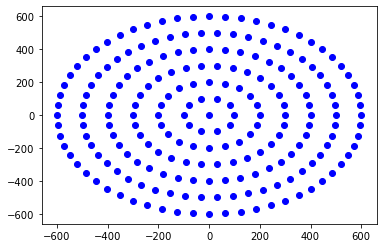

In [6]:
T = np.array([1, 10, 20, 30, 40, 50, 60])
R = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])*1000

no_boids_circle = np.sum(T)
starting_positions = np.zeros((2,no_boids_circle)) 

def rtpairs(r, n):
    for i in range(len(r)):
        for j in range(n[i]):    
            yield r[i], j*(2 * np.pi / n[i])

counter = 0
for r, t in rtpairs(R, T):
    starting_positions[0,counter] = r * np.cos(t)
    starting_positions[1,counter] = r * np.sin(t)
    counter += 1
    # plt.plot(r * np.cos(t), r * np.sin(t), 'bo')
plt.plot(starting_positions[0], starting_positions[1], 'bo')
plt.show()

In [7]:
original_positions = np.vstack((np.linspace(100,400,no_boids), np.linspace(200,1800,no_boids))) + 10*np.random.randn(original_positions.shape[0], original_positions.shape[1])
print(original_positions.shape)
original_positions = starting_positions + 1000
print(original_positions.shape)


(2, 211)
(2, 211)


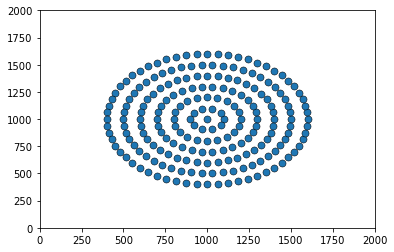

In [8]:
figure = plt.figure()
axes = plt.axes(xlim=(0, limits[0]), ylim=(0, limits[1]))

scatter = axes.scatter(original_positions[0, :], original_positions[1, :],
                       marker='o', edgecolor='k', lw=0.5, s=boid_width)

scatter

### Produce animated behaviour 

In [9]:
def animate(frame):
    update_boids(positions, velocities)
    scatter.set_offsets(positions.transpose())

In [10]:
def update_boids(positions, velocities):
    
    ### Fly towards the middle
    move_to_middle_strength = 0.001
    middle = np.mean(positions, 1)
    direction_to_middle = positions - middle[:, np.newaxis]
    velocities -= direction_to_middle * move_to_middle_strength
    

    ### Avoiding collisions
    separations = positions[:, np.newaxis, :] - positions[:, :, np.newaxis]
    squared_displacements = separations * separations
    square_distances = np.sum(squared_displacements, 0)
    alert_distance = 500
    alert_strength = 10
    far_away = square_distances > alert_distance
    separations_if_close = np.copy(separations)
    separations_if_close[0, :, :][far_away] = 0
    separations_if_close[1, :, :][far_away] = 0
    velocities += np.sum(separations_if_close, 1) * alert_strength

    
    ### Fly towards neighbouring close_birds to create swarm
    catchment_distance = 250
    catchment_strength = 0.5
    velocities -= np.sum(separations_if_close, 1) * catchment_strength
    
    
    ### Match speed with nearby close_birds
    velocity_differences = velocities[:, np.newaxis, :] - velocities[:, :, np.newaxis]
    formation_flying_distance = 1000
    formation_flying_strength = 0.01
    very_far = square_distances > formation_flying_distance
    velocity_differences_if_close = np.copy(velocity_differences)
    velocity_differences_if_close[0, :, :][very_far] = 0
    velocity_differences_if_close[1, :, :][very_far] = 0
    velocities -= np.mean(velocity_differences_if_close, 1) * formation_flying_strength

    ### Remove extreme values of velocity
    # threshold = 10
    # velocities = np.array([[threshold if vel_ > threshold else vel_ for vel_ in velocities_i] for velocities_i in velocities])
    
    ### prevent overlapping 
    relative_velocities = velocities[:, np.newaxis, :] - velocities[:, :, np.newaxis]
    borders_overlapping = np.logical_and(square_distances <= 2 * boid_width**2, square_distances >= 1.5 * boid_width**2) # when boids first start to overlap
    mostly_overlapping = square_distances <= 1.5 * boid_width**2 # when boids overlap significantly, due to high energy in swarm
    not_borders_overlapping = np.logical_not(borders_overlapping)
    relative_velocities_if_overlapping = np.copy(relative_velocities)
    relative_velocities_if_overlapping[0, :, :][not_borders_overlapping] = 0
    relative_velocities_if_overlapping[1, :, :][not_borders_overlapping] = 0
    relative_velocities_if_overlapping[0, :, :][mostly_overlapping] = 0
    relative_velocities_if_overlapping[1, :, :][mostly_overlapping] = 0
    # take current velocity and minus the relative velocity of neighbouring points to each other in direction of each other 
    # to make the birds move around each other rather than over each other
    velocities -= np.sum(relative_velocities_if_overlapping, 1)
    
    # # if any(relative_velocities_if_overlapping[:,0][0] > 0):
    #     # TODO return here and write code to incorperate the dot product of the boids incident on each others displacements, with their relative velocities, to make more realistic bouncing off each other./
    unit_vector_separations = np.round(np.nan_to_num(separations/np.linalg.norm(separations, ord=2, axis=0)),3)
    unit_relative_velocities_if_overlapping = np.round(np.nan_to_num(relative_velocities_if_overlapping/np.linalg.norm(relative_velocities_if_overlapping, ord=2, axis=0)),3)
    # # print("separation unit vectors: \n", unit_vector_separations)
    # # print("relative velocities unit vectors: \n", unit_relative_velocities_if_overlapping)
    # # print("pointwise multiplication \n", np.round(unit_relative_velocities_if_overlapping * unit_vector_separations, 3))
    # # print("dot product \n", np.round(np.sum(unit_relative_velocities_if_overlapping * unit_vector_separations, 0), 3))
    # # print("velocities matrix \n", velocities)
    # # print("sum part \n", np.sum(np.round(np.sum(unit_relative_velocities_if_overlapping * unit_vector_separations, 0), 3), 1))
    # if any(np.abs(np.sum(relative_velocities_if_overlapping, 1))[0] < np.abs(np.sum(relative_velocities_if_overlapping, 1) * np.sum(np.round(np.sum(unit_relative_velocities_if_overlapping * unit_vector_separations, 0), 3), 1))[0]):
    #     print("original change in velocities \n", np.round(np.sum(relative_velocities_if_overlapping, 1), 3))
    #     print("new change in velocities \n", np.round(np.sum(relative_velocities_if_overlapping, 1) * np.sum(np.round(np.sum(unit_relative_velocities_if_overlapping * unit_vector_separations, 0), 3), 1), 3))
    #     print("dot product \n", np.round(np.triu(np.sum(unit_relative_velocities_if_overlapping * unit_vector_separations, 0)), 3))
    #     print("sum part \n", np.round(np.sum(np.triu(np.sum(unit_relative_velocities_if_overlapping * unit_vector_separations, 0)), 1), 3))
    # # print("original final_velocities \n", velocities - np.sum(relative_velocities_if_overlapping, 1))
    # # print("new final_velocities \n", velocities + np.sum(relative_velocities_if_overlapping, 1) * np.sum(np.round(np.sum(unit_relative_velocities_if_overlapping * unit_vector_separations, 0), 3), 1))
    dot_product = np.sum(np.triu(np.sum(unit_relative_velocities_if_overlapping * unit_vector_separations, 0)), 1)
    velocities += np.sum(relative_velocities_if_overlapping, 1) * dot_product
    # # dot_product_of_incident_vector_with_incident_velocity = unit_vector_separations @ np.transpose(unit_relative_velocities_if_overlapping, (0,2,1))
    # # print(dot_product_of_incident_vector_with_incident_velocity)
    # # velocities -= np.sum(relative_velocities_if_overlapping, 1) #@ separations
    # # velocities[20000]
    
    ### update positions
    positions += velocities
    
    


In [11]:
positions = original_positions.copy()
velocities = original_velocities.copy()

anim = animation.FuncAnimation(figure, animate, frames=200, interval=50)

HTML(anim.to_jshtml())

C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


In [12]:
positions = original_positions.copy()
velocities = original_velocities.copy()

anim = animation.FuncAnimation(figure, animate, frames=200, interval=50)

HTML(anim.to_jshtml())

C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
